In [12]:
!pip install -q torch torchvision altair seaborn
!git clone -q https://github.com/afspies/icl_dl_cw2_utils
from icl_dl_cw2_utils.utils.plotting import plot_tsne
from pathlib import Path
import tqdm

fatal: destination path 'icl_dl_cw2_utils' already exists and is not an empty directory.


In [13]:
WORKING_ENV = 'COLAB' # Can be LABS, COLAB or PAPERSPACE
assert WORKING_ENV in ['LABS', 'COLAB', 'PAPERSPACE']

if WORKING_ENV == 'COLAB':
    from google.colab import drive
    %load_ext google.colab.data_table
    content_path = '/content/drive/MyDrive/dl_cw_2'
    data_path = './data/'
    drive.mount('/content/drive/') # Outputs will be saved in your google drive

elif WORKING_ENV == 'LABS':
    content_path = '~/Documents/dl_cw_2' # You may want to change this
    # Your python env and training data should be on bitbucket
    data_path = f'/vol/bitbucket/{USERNAME}/dl_cw_data/'

else: # Using Paperspace
    # Paperspace does not properly render animated progress bars
    # Strongly recommend using the JupyterLab UI instead of theirs
    !pip install ipywidgets
    content_path = '/notebooks'
    data_path = './data/'

content_path = Path(content_path)

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [14]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader, sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from torch.autograd import Variable as V
import torch.nn.functional as F
import matplotlib.pyplot as plt

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

if not os.path.exists(content_path/'CW_VAE/'):
    os.makedirs(content_path/'CW_VAE/')

if not os.path.exists(data_path):
    os.makedirs(data_path)

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

GPU = True # Choose whether to use GPU
if GPU:
    device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(f'Using {device}')

Using cuda


In [15]:
# Necessary Hyperparameters
batch_size = 32


# (Optionally) Modify transformations on input
transform = transforms.Compose(
    [transforms.ToTensor()
    #transforms.RandomCrop(32, padding=4),
    #transforms.RandomHorizontalFlip(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

transform_test = transforms.Compose(
    [transforms.ToTensor()
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    ])

# (Optionally) Modify the network's output for visualizing your images
def denorm(x):
    return x

In [ ]:
# Download the Cifar10 dataset
train_dat = datasets.CIFAR10(data_path, train=True, download=True,
                             transform=transform)
loader_train = DataLoader(train_dat, batch_size, shuffle=True)

test_dat = datasets.CIFAR10(data_path, train=False, transform=transform_test)
loader_test = DataLoader(test_dat, batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Don't change
sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[:32, :, :, :]
#print(torch.max(fixed_input))
#print(torch.min(fixed_input))
save_image(fixed_input, content_path/'CW_VAE/image_original.png')

Files already downloaded and verified


In [18]:
# Minst dataset
train_dat = datasets.MNIST(
    data_path, train=True, download=True, transform=transform
)
test_dat = datasets.MNIST(data_path, train=False, transform=transform)

loader_train = DataLoader(train_dat, batch_size, shuffle=True)
loader_test = DataLoader(test_dat, batch_size, shuffle=False)

classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

# Don't change
sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[:32, :, :, :]
save_image(fixed_input, content_path/'CW_VAE/image_original.png')

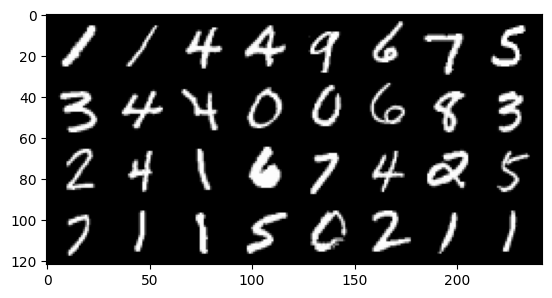

1     1     4     4     9     6     7     5     3     4     4     0     0     6     8     3     2     4     1     6     7     4     2     5     7     1     1     5     0     2     1     1    


In [19]:
# Show an example
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(loader_train)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [20]:
class EncoderModule(nn.Module):
    def __init__(self, input_channels, output_channels, stride, kernel, pad):
        super().__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=kernel, padding=pad, stride=stride)
        self.bn = nn.BatchNorm2d(output_channels)
        self.relu = nn.LeakyReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

In [21]:
class Encoder(nn.Module):
    def __init__(self, color_channels, pooling_kernels, n_neurons_in_middle_layer):
        self.n_neurons_in_middle_layer = n_neurons_in_middle_layer
        super().__init__()
        self.bottle = EncoderModule(color_channels, 32, stride=1, kernel=1, pad=0)
        self.m1 = EncoderModule(32, 64, stride=1, kernel=3, pad=1)
        self.m2 = EncoderModule(64, 128, stride=pooling_kernels[0], kernel=3, pad=1)
        self.m3 = EncoderModule(128, 256, stride=pooling_kernels[1], kernel=3, pad=1)

    def forward(self, x):
        out = self.m3(self.m2(self.m1(self.bottle(x))))
        return out.view(-1, self.n_neurons_in_middle_layer)

In [22]:
class DecoderModule(nn.Module):
    def __init__(self, input_channels, output_channels, stride, activation="relu"):
        super().__init__()
        self.convt = nn.ConvTranspose2d(input_channels, output_channels, kernel_size=stride, stride=stride)
        self.bn = nn.BatchNorm2d(output_channels)
        if activation == "relu":
            self.activation = nn.LeakyReLU()
        elif activation == "sigmoid":
            self.activation = nn.Sigmoid()

    def forward(self, x):
        return self.activation(self.bn(self.convt(x)))

In [23]:
class Decoder(nn.Module):
    def __init__(self, color_channels, pooling_kernels, decoder_input_size):
        self.decoder_input_size = decoder_input_size
        super().__init__()
        self.m1 = DecoderModule(256, 128, stride=1)
        self.m2 = DecoderModule(128, 64, stride=pooling_kernels[1])
        self.m3 = DecoderModule(64, 32, stride=pooling_kernels[0])
        self.bottle = DecoderModule(32, color_channels, stride=1, activation="sigmoid")

    def forward(self, x):
        out = x.view(-1, 256, self.decoder_input_size, self.decoder_input_size)
        out = self.m3(self.m2(self.m1(out)))
        return self.bottle(out)

In [32]:
class VAE(nn.Module):
    def __init__(self, dataset):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        assert dataset in ["mnist" ,"fashion-mnist", "cifar", "stl"]

        super().__init__()
        # # latent features
        self.n_latent_features = 64

        # resolution
        # mnist, fashion-mnist : 28 -> 14 -> 7
        # cifar : 32 -> 8 -> 4
        # stl : 96 -> 24 -> 6
        if dataset in ["mnist", "fashion-mnist"]:
            pooling_kernel = [2, 2]
            encoder_output_size = 7
        elif dataset == "cifar":
            pooling_kernel = [4, 2]
            encoder_output_size = 4
        elif dataset == "stl":
            pooling_kernel = [4, 4]
            encoder_output_size = 6

        # color channels
        if dataset in ["mnist", "fashion-mnist"]:
            color_channels = 1
        else:
            color_channels = 3

        # # neurons int middle layer
        n_neurons_middle_layer = 256 * encoder_output_size * encoder_output_size

        # Encoder
        self.encoder = Encoder(color_channels, pooling_kernel, n_neurons_middle_layer)
        # Middle
        self.fc1 = nn.Linear(n_neurons_middle_layer, self.n_latent_features)
        self.fc2 = nn.Linear(n_neurons_middle_layer, self.n_latent_features)
        self.fc3 = nn.Linear(self.n_latent_features, n_neurons_middle_layer)
        # Decoder
        self.decoder = Decoder(color_channels, pooling_kernel, encoder_output_size)


    def _reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.randn(*mu.size()).to(self.device)
        z = mu + std * esp
        return z

    def _bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self._reparameterize(mu, logvar)
        return z, mu, logvar

    def sampling(self):
        # assume latent features space ~ N(0, 1)
        z = torch.randn(64, self.n_latent_features).to(self.device)
        z = self.fc3(z)
        # decode
        return self.decoder(z)

    def forward(self, x):
        # Encoder
        h = self.encoder(x)
        # Bottle-neck
        z, mu, logvar = self._bottleneck(h)
        # decoder
        z = self.fc3(z)
        d = self.decoder(z)
        return d, mu, logvar


model = VAE('mnist').to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))

Total number of parameters is: 2884099


In [ ]:
# optimizer
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# *CODE FOR PART 1.1b IN THIS CELL*

def loss_function_VAE(recon_x, x, mu, logvar, beta):
    recon_loss = reconstruction_loss(recon_x, x)
    kld_loss = beta * kl_loss(recon_x, x, mu, logvar, beta)
    return recon_loss + kld_loss

def reconstruction_loss(recon_x, x):
    #recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    #recons_loss = F.l1_loss(recon_x, x)
    recon_loss = nn.BCELoss(size_average=False)(recon_x, x)  # use this one for the mnist dataset
    return recon_loss

def kl_loss(recon_x, x, mu, logvar, beta):
    kld_loss = 0.5 * torch.sum(-1 - logvar + mu.pow(2) + logvar.exp(), dim=1)
    kld_loss = torch.mean(kld_loss)
    return kld_loss



beta = 0.2
num_epochs = 20

total_loss_train = []
total_loss_test = []
recon_loss_train = []
recon_loss_test = []
kld_loss_train = []
kld_loss_test = []

mu_sum = []
logvar_sum = []

# <- You may wish to add logging info here
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    recon_loss = 0
    kld_loss = 0
    counter = 0
    # <- You may wish to add logging info here
    with torch.autograd.set_detect_anomaly(True):
        with tqdm.tqdm(loader_train, unit="batch") as tepoch:
            for batch_idx, (data, _) in enumerate(tepoch):
                counter += 1
                data = data.to(device)
                optimizer.zero_grad()
                recon_data, mu, logvar = model(data)
                loss = loss_function_VAE(recon_data, data, mu, logvar, beta)

                mu_sum.append(torch.mean(torch.sum(torch.abs(mu), dim=1)).item())
                logvar_sum.append(torch.mean(torch.sum(logvar, dim=1)).item())

                loss.backward()
                total_loss += loss.item()
                optimizer.step()

                recon_loss += reconstruction_loss(recon_data, data).item()
                kld_loss += kl_loss(recon_data, data, mu, logvar, beta).item()

                if batch_idx % 20 == 0:
                    tepoch.set_description(f"Epoch {epoch}")
                    tepoch.set_postfix(loss=loss.item() / len(data))
            total_loss_train.append(total_loss / counter) # ??
            recon_loss_train.append(reconstruction_loss(recon_data, data).item())
            kld_loss_train.append(kl_loss(recon_data, data, mu, logvar, beta).item())

    model.eval()
    total_loss = 0
    recon_loss = 0
    kld_loss = 0
    counter = 0
    # <- You may wish to add logging info here
    with tqdm.tqdm(loader_test, unit="batch") as tepoch:
        for batch_idx, (data, _) in enumerate(tepoch):
            counter += 1
            data = data.to(device)
            recon_data, mu, logvar = model(data)
            loss = loss_function_VAE(recon_data, data, mu, logvar, beta)
            total_loss += loss.item()

            recon_loss += reconstruction_loss(recon_data, data).item()
            kld_loss += kl_loss(recon_data, data, mu, logvar, beta).item()

            if batch_idx % 20 == 0:
                tepoch.set_description(f"Epoch {epoch}")
                tepoch.set_postfix(loss=loss.item() / len(data))
        total_loss_test.append(total_loss / counter) # ??
        recon_loss_test.append(reconstruction_loss(recon_data, data).item())
        kld_loss_test.append(kl_loss(recon_data, data, mu, logvar, beta).item())

    # # save the model
    # if epoch == num_epochs - 1:
    #     example_inputs = torch.rand(64, 3, 32, 32).to(device)
    #     with torch.no_grad():
    #         torch.jit.save(torch.jit.trace(model, (example_inputs), check_trace=False),
    #             content_path/'CW_VAE/VAE_model.pth')

  0%|          | 0/1875 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Epoch 0:  14%|█▍        | 268/1875 [00:13<01:18, 20.52batch/s, loss=46.1]

In [ ]:
# *CODE FOR PART 1.2a IN THIS CELL*
plt.figure(1, figsize=(8, 6), dpi=80)
xrange1 = [i for i in range(num_epochs)]
plt.plot(xrange1, total_loss_train, label='training loss')
plt.plot(xrange1, total_loss_test, label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.figure(2, figsize=(8, 6), dpi=80)
plt.plot(xrange1, recon_loss_train, label='training reconstruction loss')
plt.plot(xrange1, recon_loss_test, label='validation reconstruction loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()


plt.figure(3, figsize=(8, 6), dpi=80)
plt.plot(xrange1, kld_loss_train, label='training KL loss')
plt.plot(xrange1, kld_loss_test, label='validation KL loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
# load the model
print('Input images')
print('-'*50)

sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[0:32, :, :, :]
# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure()
show(img)
plt.savefig('/content/drive/MyDrive/dl_cw_2/Figures for the report/input images.pdf', bbox_inches='tight')

print('Reconstructed images')
print('-'*50)
with torch.no_grad():
    # visualize the reconstructed images of the last batch of test set

    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    recon_batch, mu, logvar = model(fixed_input.to(device))
    #######################################################################
    #                       ** END OF YOUR CODE **
    #######################################################################

    recon_batch = recon_batch.cpu()
    recon_batch = make_grid(denorm(recon_batch), nrow=8, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    plt.figure()
    show(recon_batch)
    plt.savefig('/content/drive/MyDrive/dl_cw_2/Figures for the report/reconstructed images.pdf', bbox_inches='tight')

print('Generated Images')
print('-'*50)
model.eval()
n_samples = 32
z = torch.randn(n_samples, 64).to(device)
with torch.no_grad():
    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    z = model.fc3(z)
    z = z.view(-1, 64, 1, 1)
    samples = model.decoder(z)
    #######################################################################
    #                       ** END OF YOUR CODE **
    #######################################################################

    samples = samples.cpu()
    samples = make_grid(denorm(samples), nrow=16, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    plt.figure(figsize = (8,8))
    show(samples)
    plt.savefig('/content/drive/MyDrive/dl_cw_2/Figures for the report/generated images.pdf', bbox_inches='tight')


In [ ]:
plt.figure(1, figsize=(8, 6), dpi=80)
plt.plot(mu_sum[0: 100:], label='sum of mu')
plt.xlabel('epochs')
plt.ylabel('sum of mu')
plt.legend()

plt.figure(2, figsize=(8, 6), dpi=80)
plt.plot(logvar_sum[0: 100:], label='sum of log variance')
plt.xlabel('epochs')
plt.ylabel('sum of logvar')
plt.legend()
plt.show()